# Representative Cocycles

Ripser is cohomology based, and it returns representative cocycles for each cohomology class generator returned from the persistent cohomology algorithm.  

Recall that cohomology is the dual of homology, and that a coboundary operator is the adjoint operator of the boundary operator; that is, the coboundary operator takes $d$ forms to $d+1$ forms.  For instance, the coboundary operator $\delta_0$ takes 0-forms (scalar functions on vertices) to 1-forms on a vector space (functions on oriented edges), and $\delta_1$ takes 1-forms to 2-forms (functions on oriented triangles).  A *d-dimensional cocycle* is a $d$-form whose coboundary $\delta_d$ is zero.  As with homology, applying the coboundary operator twice yields zero; $\delta_{d}\delta_{d-1} = 0$, so the image of $\delta_{d-1}$ is in the kernel of $\delta_{d}$, and we can take the quotient $Ker(\delta_{d}) / Im(\delta_{d-1})$ to get the *dth comology group*.  A particular equivalence class of $d$-forms in this group which is equivalent mod $Im(\delta_{d-1})$ is referred to as a *cohomology class*. The persistent cohomology algorithm computes set of cohomology class generators which generate the group, and whose births and deaths are represented in the persistence diagram (NOTE: cohomological birth is actually homological death, and vice versa, as we will see in our example below, but we still use the homology birth/death convention when plotting the diagrams).  The persistence algorithm returns a representative cocycle for each generator class, which can extract from ripser, and which we now explore on a simple example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import tadasets

Now we setup some code that will be used to plot the cocycles

In [2]:
def drawLineColored(X, C):
    for i in range(X.shape[0]-1):
        plt.plot(X[i:i+2, 0], X[i:i+2, 1], c=C[i, :], lineWidth = 3)

def plotCocycle2D(D, X, cocycle, thresh):
    """
    Given a 2D point cloud X, display a cocycle projected
    onto edges under a given threshold "thresh"
    """
    #Plot all edges under the threshold
    N = X.shape[0]
    t = np.linspace(0, 1, 10)
    c = plt.get_cmap('Greys')
    C = c(np.array(np.round(np.linspace(0, 255, len(t))), dtype=np.int32))
    C = C[:, 0:3]

    for i in range(N):
        for j in range(N):
            if D[i, j] <= thresh:
                Y = np.zeros((len(t), 2))
                Y[:, 0] = X[i, 0] + t*(X[j, 0] - X[i, 0])
                Y[:, 1] = X[i, 1] + t*(X[j, 1] - X[i, 1])
                drawLineColored(Y, C)
    #Plot cocycle projected to edges under the chosen threshold
    for k in range(cocycle.shape[0]):
        [i, j, val] = cocycle[k, :]
        if D[i, j] <= thresh:
            [i, j] = [min(i, j), max(i, j)]
            a = 0.5*(X[i, :] + X[j, :])
            plt.text(a[0], a[1], '%g'%val, color='b')
    #Plot vertex labels
    for i in range(N):
        plt.text(X[i, 0], X[i, 1], '%i'%i, color='r')
    plt.axis('equal')

Now we setup noisy circle with 12 points

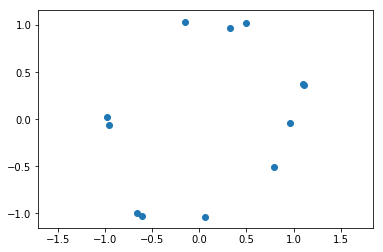

In [3]:
np.random.seed(9)
x = tadasets.dsphere(n=12, d=1, noise=0.1)

plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')
plt.show()

And we run ripser, turning on a flag that indicates that we want to store the cocycles, and doing the computation over the field $\mathbb{Z}_{17}$ just to prove a point

In [4]:
result = ripser(x, coeff=17, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']

Now find the index of the maximum persistence point in the diagram and highlight that point with a black x.  This is the point whose representative cocycle we will examine (actually there is only one point in this example, so this is trivial)

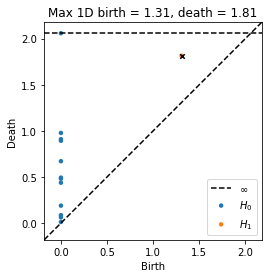

In [5]:
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

Now we examine the cocycle, drawing edges with length less than or equal to the death time.  We will display the indices of vertices in red and the value of cocycle on edges in blue.  Edge orientations are drawn as shades of gray, where the edge is oriented from black to white.  If an edge is not labeled, it means the cocycle evaluates to zero on that edge.  

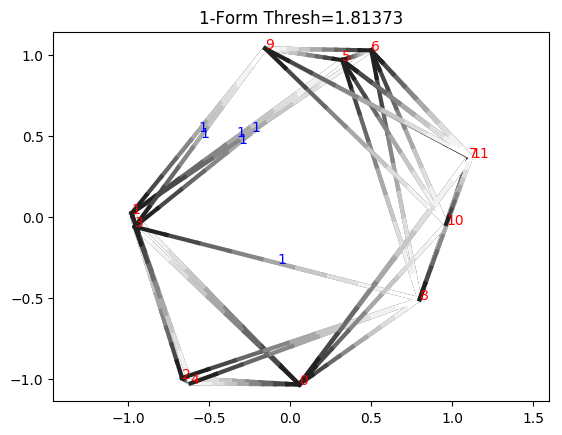

In [6]:
cocycle = cocycles[1][idx]
thresh = dgm1[idx, 1] #Project cocycle onto edges less than or equal to death time
plotCocycle2D(D, x, cocycle, thresh)
plt.title("1-Form Thresh=%g"%thresh)
plt.show()

Notice how this is not actually a valid cocycle yet, because integrating along triangle 0_3_8, we have 1 + 0 + 0, which is not 0 (mod 17).  This is because the cocycle class actually only exists in the range $[b_i, d_i)$, where $b_i$ and $d_i$ are the birth and death times, respectively.  If we go slightly under the death time, we see we do form a valid cocycle

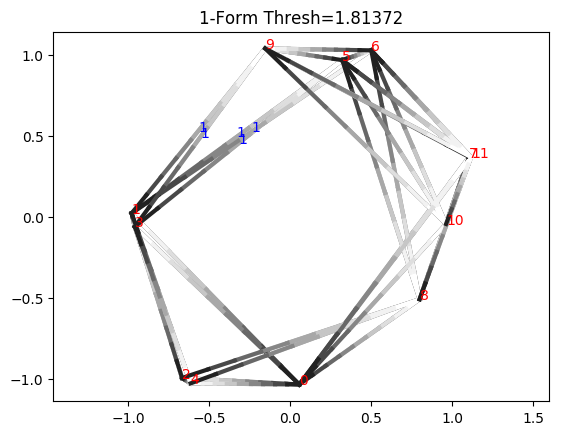

In [7]:
thresh = dgm1[idx, 1]-0.00001 #Project cocycle onto edges less slightly less than the death time
plotCocycle2D(D, x, cocycle, thresh)
plt.title("1-Form Thresh=%g"%thresh)
plt.show()

The death edge between 3_8 has been removed.  For the remaining triangles, we can now verify that the cocycle condition is satisfied.  For instance, for triangle 0_2_11, we have 1 + 16 + 0 = 17 = 0 (mod 17).  Along triangle 0_1_2 we have 0 + 1 - 1 (since the edge 2_0 is negatively oriented), which is 0 (mod 17).

We can verify that this is a valid cocycle all the way down to the birth time

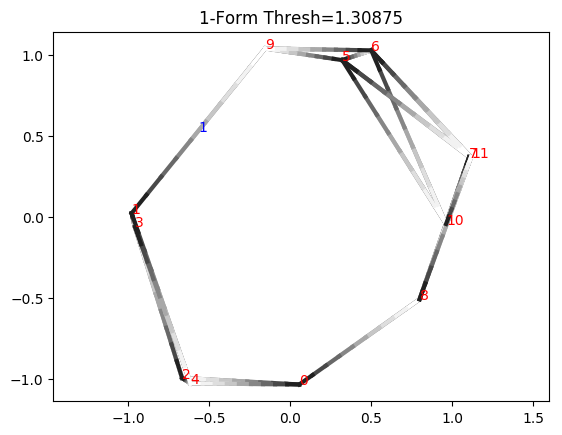

In [8]:
thresh = dgm1[idx, 0] #Project cocycle onto edges that have lengths less than or equal to the birth time
plotCocycle2D(D, x, cocycle, thresh)
plt.title("1-Form Thresh=%g"%thresh)
plt.show()